The dataset belongs to a cab aggregator service. Their customers can download their app on smartphones and book a cab from any where in the cities they operate in. They, in turn search for cabs from various service providers and provide the best option to their client across available options. They have been in operation for little less than a year now. During this period, they have captured 'surge_pricing_type' from the service providers.


#### Data Dictionary



Trip_ID - ID for TRIP (Can not be used for purposes of modelling)

Trip_Distance - The distance for the trip requested by the customer

Type_of_Cab - Category of the cab requested by the customer

Customer_Since_Months - Customer using cab services since n months; 0 month means current month

Life_Style_Index - Proprietary index created by dataset authorizer showing lifestyle of the customer based on their behaviour

Confidence_Life_Style_Index - Category showing confidence on the index mentioned above

Destination_Type - Sigma Cabs divides any destination in one of the 14 categories.

Customer_Rating - Average of life time ratings of the customer till date

Cancellation_Last_1Month - Number of trips cancelled by the customer in last 1 month

Var1, Var2 and Var3 - Continuous variables masked by the company. Can be used for modelling purposes

Gender - Gender of the customer

Surge_Pricing_Type - Predictor variable can be of 3 types

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

import h2o
from h2o.automl import H2OAutoML

sns.set_style("whitegrid") # Plotting style
np.random.seed(7) # seeding random number generator

%matplotlib inline

### Data collection

In [7]:
trips_train_raw = pd.read_csv('datasets/train.csv')
trips_test_raw = pd.read_csv('datasets/test.csv')

In [8]:
trips_train_raw.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


### Data understanding

In [9]:
### support functions ###

# get object datatype col names

def get_datatypes(df, datatype):
    '''
    Get datatypes of column names
    
    Params:
        df : dataframe
        datatype : str
    return:
        dtypes_list : list
    '''
    
    return [col for col in df.columns if df[col].dtypes== datatype]

# print unique values
def print_unique_values(df, dtypes_list):
    for col in dtypes_list:
        print('Unique values in {} column are  {} : {} \n'.format(col, df[col].ffill().nunique(), df[col].ffill().unique()))

In [10]:
print('-'*15, 'Train Dataset information', '-'*15, '\n')

# info
trips_train_raw.info()
print('-'*15, 'Datatypes in data', '-'*15, '\n')

print('-'*5,'Object datatypes', '-'*5, '\n')
object_dtypes_list = get_datatypes(trips_train_raw, 'O')    
print('Object type columns names are: \n', object_dtypes_list)
print_unique_values(trips_train_raw, object_dtypes_list)

--------------- Train Dataset information --------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12

In [11]:
print('-'*15, 'Test Dataset information', '-'*15, '\n')

# info
trips_test_raw.info()
print('-'*15, 'Datatypes in data', '-'*15, '\n')

print('-'*5,'Object datatypes', '-'*5, '\n')   
print('Object type columns names are: \n', object_dtypes_list)
print_unique_values(trips_test_raw, object_dtypes_list)

--------------- Test Dataset information --------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87395 entries, 0 to 87394
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Trip_ID                      87395 non-null  object 
 1   Trip_Distance                87395 non-null  float64
 2   Type_of_Cab                  74237 non-null  object 
 3   Customer_Since_Months        83429 non-null  float64
 4   Life_Style_Index             74068 non-null  float64
 5   Confidence_Life_Style_Index  74068 non-null  object 
 6   Destination_Type             87395 non-null  object 
 7   Customer_Rating              87395 non-null  float64
 8   Cancellation_Last_1Month     87395 non-null  int64  
 9   Var1                         40606 non-null  float64
 10  Var2                         87395 non-null  int64  
 11  Var3                         87395 non-null  int64  
 12  Gender         

In [12]:
trips_train_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_Distance,131662.0,44.200909,25.522882,0.31000,24.58000,38.20000,60.73000,109.23000
Customer_Since_Months,125742.0,6.016661,3.626887,0.00000,3.00000,6.00000,10.00000,10.00000
Life_Style_Index,111469.0,2.802064,0.225796,1.59638,2.65473,2.79805,2.94678,4.87511
Customer_Rating,131662.0,2.849458,0.980675,0.00125,2.15250,2.89500,3.58250,5.00000
Cancellation_Last_1Month,131662.0,0.782838,1.037559,0.00000,0.00000,0.00000,1.00000,8.00000
Var1,60632.0,64.202698,21.820447,30.00000,46.00000,61.00000,80.00000,210.00000
Var2,131662.0,51.202800,4.986142,40.00000,48.00000,50.00000,54.00000,124.00000
Var3,131662.0,75.099019,11.578278,52.00000,67.00000,74.00000,82.00000,206.00000
Surge_Pricing_Type,131662.0,2.155747,0.738164,1.00000,2.00000,2.00000,3.00000,3.00000


## Exploratory data analysis

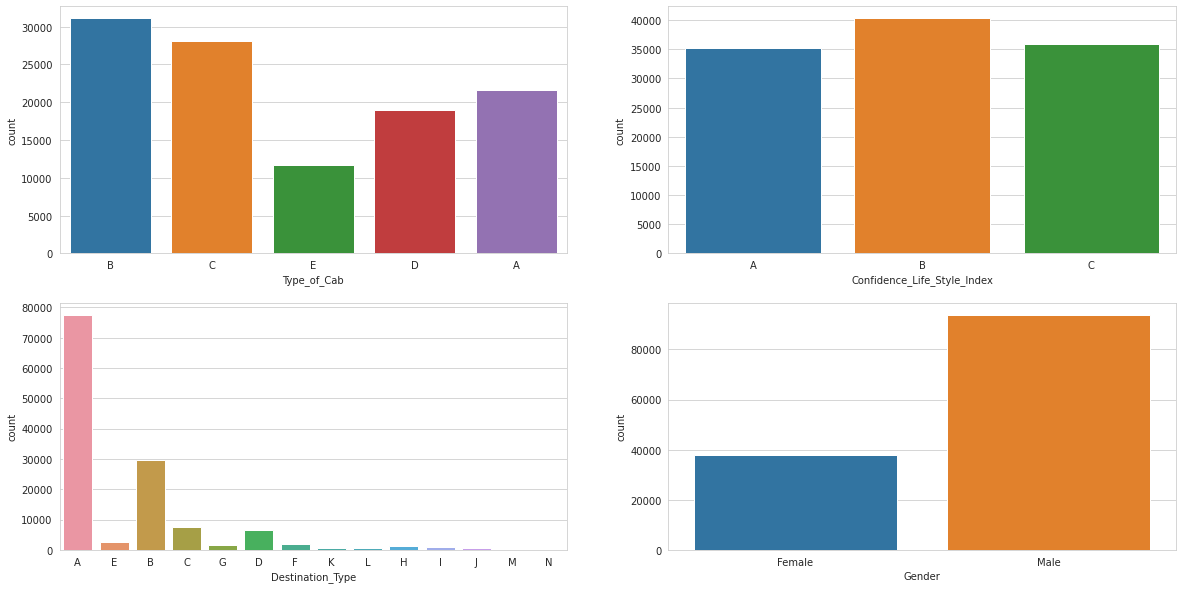

In [47]:
row = len(object_dtypes_list)//2 
cols = 2
sub=1
fig = plt.figure(figsize=(20,10))
for col in object_dtypes_list:
    if col != 'Trip_ID':
      plt.subplot(row, cols, sub)
      plt.xlabel(col)
      sns.countplot(x=col, data=trips_train_raw)
      sub += 1
plt.show()

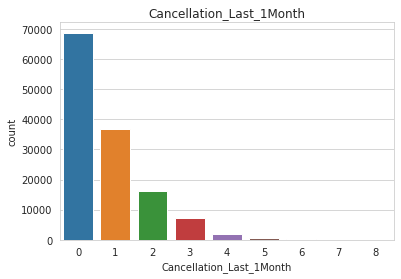

In [17]:
sns.countplot(trips_train_raw['Cancellation_Last_1Month'])

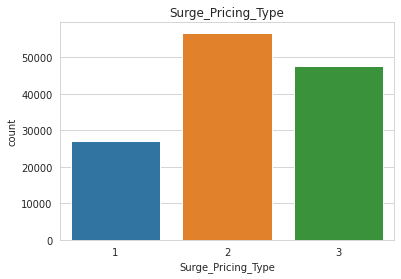

In [43]:
# label
sns.countplot(trips_train_raw['Surge_Pricing_Type'])

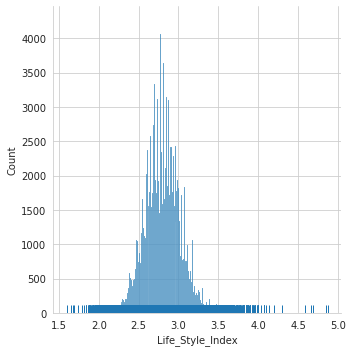

In [85]:
sns.displot(trips_train_raw['Life_Style_Index'], rug=True)
plt.show()

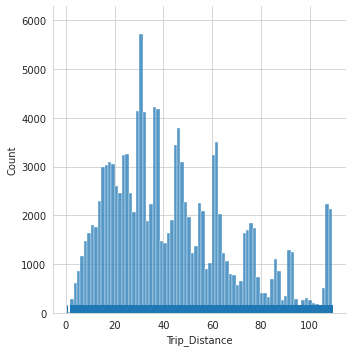

In [86]:
sns.displot(trips_train_raw['Trip_Distance'], rug=True)
plt.show()

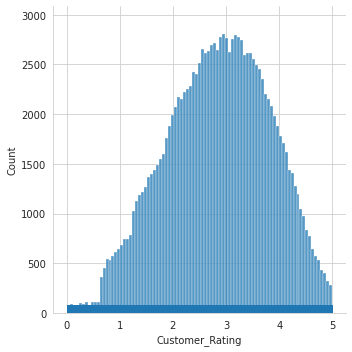

In [87]:
sns.displot(trips_train_raw['Customer_Rating'], rug=True)
plt.show()

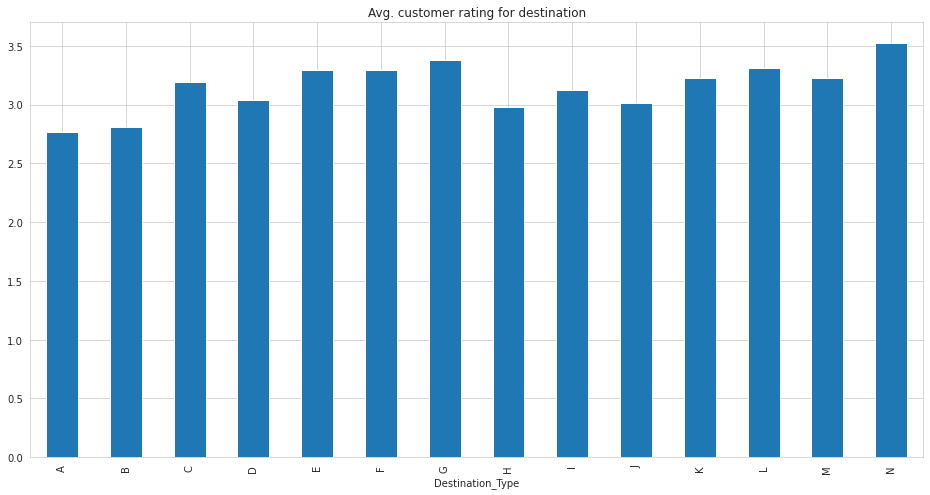

In [73]:
 trips_train_raw.groupby("Destination_Type")["Customer_Rating"].mean().plot.bar(title = 'Avg. customer rating for destination', figsize=(16, 8));

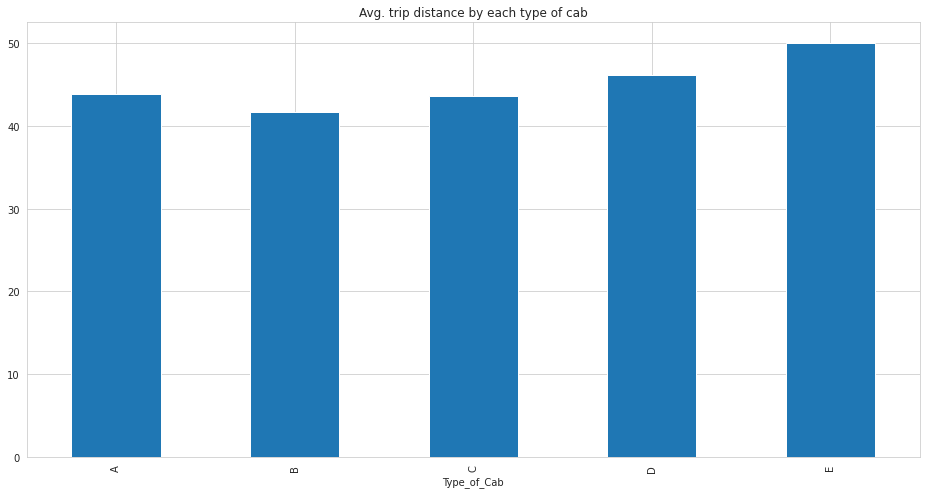

In [74]:
 trips_train_raw.groupby("Type_of_Cab")["Trip_Distance"].mean().plot.bar(title = 'Avg. trip distance by each type of cab', figsize=(16, 8));

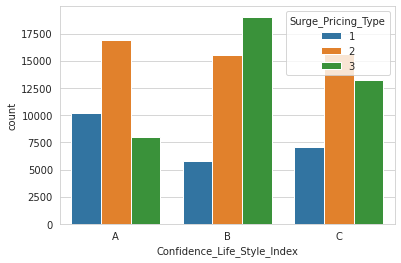

In [84]:
ax = sns.countplot(x='Confidence_Life_Style_Index', data=trips_train_raw, hue='Surge_Pricing_Type');

Findings:
- Avg. customer rating per destination, N has the highest whereas A has the lowest.
- Trip distance per cab type, E has the highest and B has the lowest
- Surge pricing vs confidence lifestyle index: category 2 in surge pricing is highest in A and C confidence index. 

### Data preparation

In [88]:
# create a copy
train_prep=trips_train_raw.copy()
test_prep=trips_test_raw.copy()

# label
label = train_prep[['Surge_Pricing_Type']]

# drop label and trip_id column
train_prep.drop(['Surge_Pricing_Type', 'Trip_ID'], axis = 1, inplace=True)
test_prep.drop(['Trip_ID'], axis = 1, inplace=True)

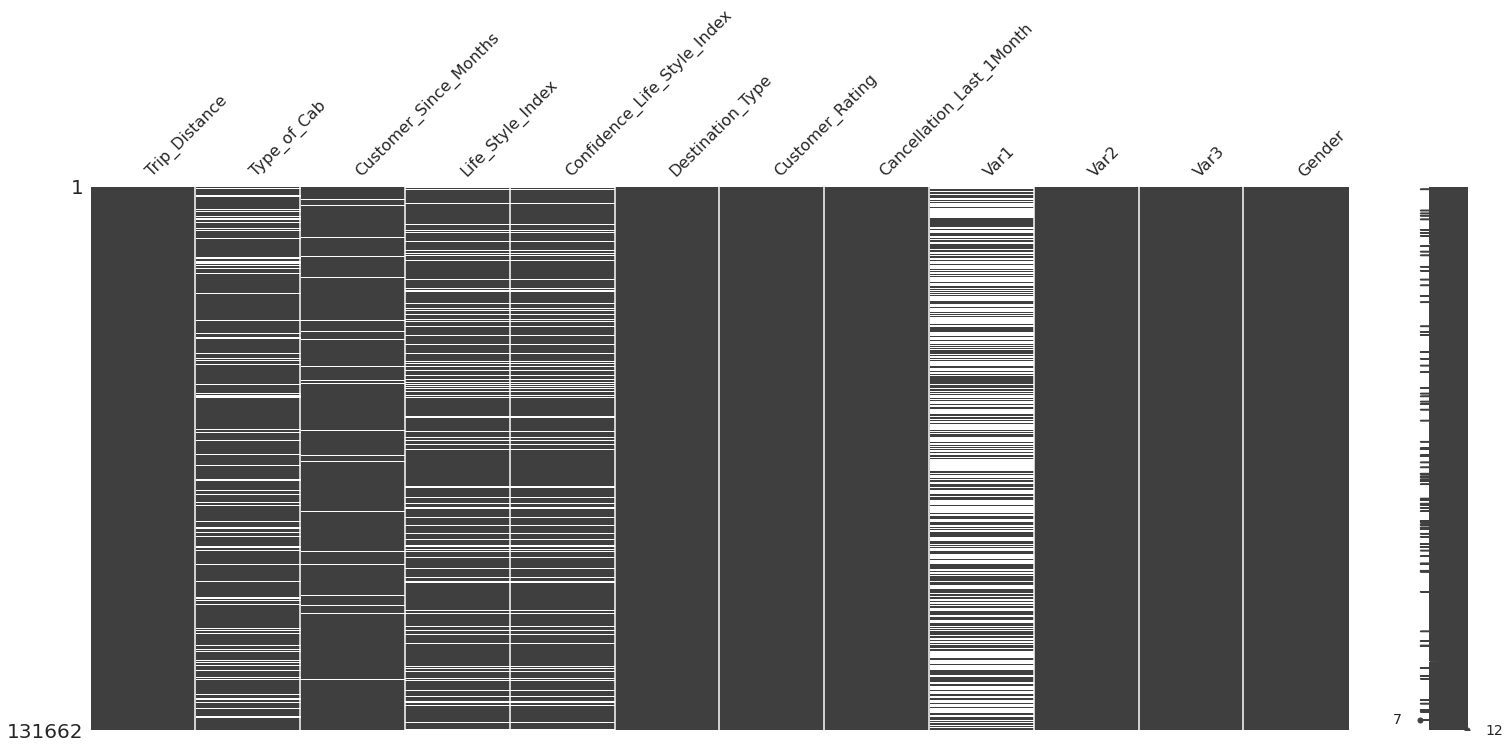

In [89]:
msno.matrix(train_prep);

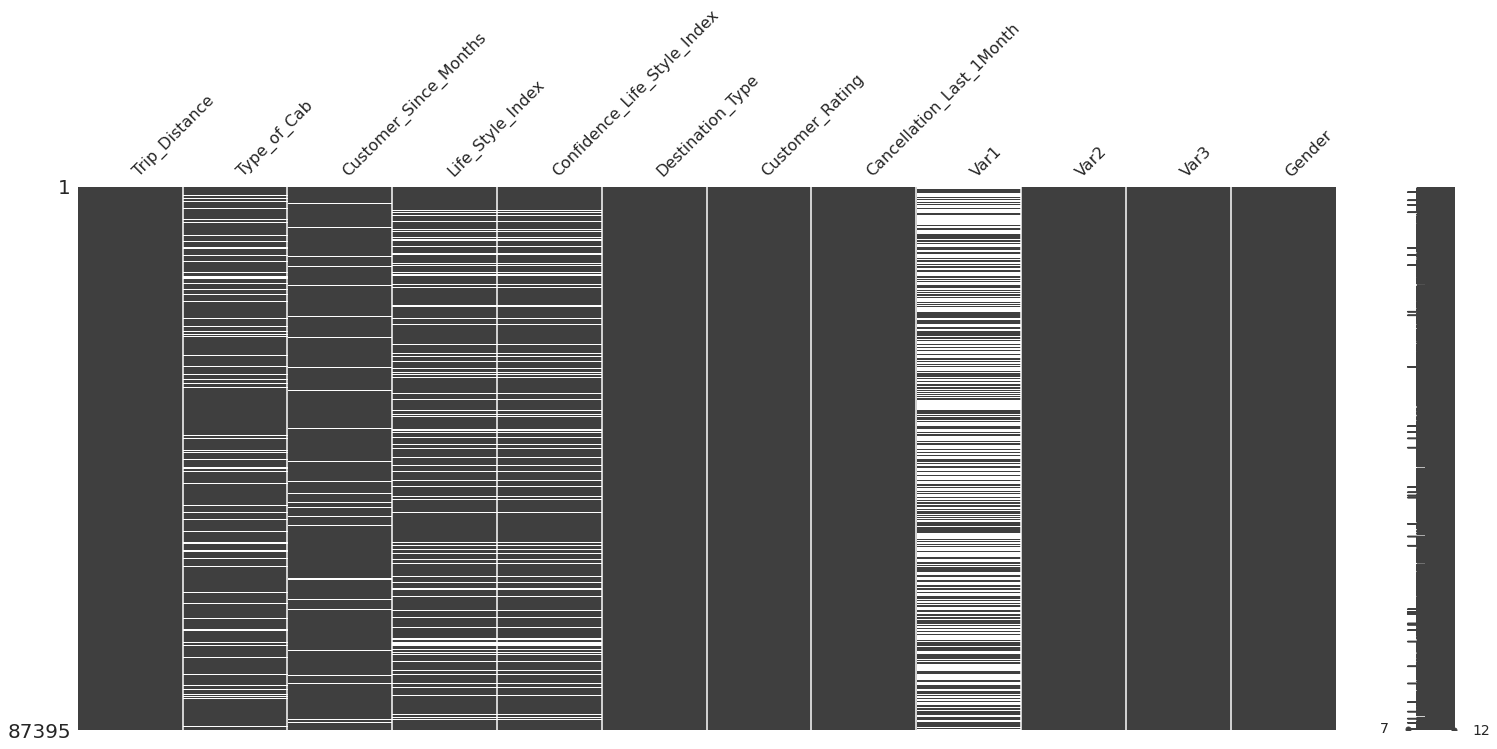

In [90]:
msno.matrix(test_prep);

#### Working on missing values

- Type_of_Cab : missing values can be replaced with different cab type eg. 'F'
- Customer_Since_Months : Here, max no. of months is till 10. the missing can be noted as greater than 10 (or highest number)
- Confidence_Life_Style_Index : a new string is created and alloted
- for rest of the columns, multiple imputations is prescribed

In [91]:
# Type of cab
train_prep['Type_of_Cab'].fillna("F", inplace=True)
test_prep['Type_of_Cab'].fillna("F", inplace=True)

# Customer_Since_Months
train_prep['Customer_Since_Months'].fillna(12, inplace=True)
test_prep['Customer_Since_Months'].fillna(12, inplace=True)

# confidence lifestyle index
train_prep['Confidence_Life_Style_Index'].fillna("D", inplace=True)
test_prep['Confidence_Life_Style_Index'].fillna("D", inplace=True)

#### multiple iterations with chained equations

Create dummies for categorical columns in data

In [92]:
# cols for onehot encoding
cal_cols = object_dtypes_list.remove('Trip_ID')

# get dummies
train_prep= pd.get_dummies(train_prep, columns=cal_cols)
test_prep= pd.get_dummies(test_prep, columns=cal_cols)

train_prep.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_A,Type_of_Cab_B,Type_of_Cab_C,Type_of_Cab_D,Type_of_Cab_E,Type_of_Cab_F,Confidence_Life_Style_Index_A,Confidence_Life_Style_Index_B,Confidence_Life_Style_Index_C,Confidence_Life_Style_Index_D,Destination_Type_A,Destination_Type_B,Destination_Type_C,Destination_Type_D,Destination_Type_E,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Female,Gender_Male
0,6.77,1.0,2.42769,3.90500,0,40.0,46,60,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,29.47,10.0,2.78245,3.45000,0,38.0,56,78,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,41.58,10.0,NaN,3.50125,2,NaN,56,77,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,61.56,10.0,NaN,3.45375,0,NaN,52,74,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,54.95,10.0,3.03453,3.40250,4,51.0,49,102,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# multiple imputation
imp = IterativeImputer()

# fit the data
imp.fit(train_prep)

# transform
train_prep_filled = imp.transform(train_prep)
test_prep_filled = imp.transform(test_prep)

In [27]:
train_prep_filled= pd.DataFrame(train_prep_filled, columns = train_prep.columns)
test_prep_filled= pd.DataFrame(test_prep_filled, columns = test_prep.columns)
train_prep_filled.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Type_of_Cab_A,Type_of_Cab_B,Type_of_Cab_C,Type_of_Cab_D,Type_of_Cab_E,Type_of_Cab_F,Confidence_Life_Style_Index_A,Confidence_Life_Style_Index_B,Confidence_Life_Style_Index_C,Confidence_Life_Style_Index_D,Destination_Type_A,Destination_Type_B,Destination_Type_C,Destination_Type_D,Destination_Type_E,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Female,Gender_Male
count,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.285694,2.802204,2.849458,0.782838,64.671536,51.202800,75.099019,0.163821,0.236484,0.213592,0.144241,0.088363,0.153499,0.266949,0.306505,0.273177,0.153370,0.589365,0.224476,0.056843,0.050037,0.020636,0.014811,0.011309,0.009570,0.006175,0.005279,0.005165,0.004884,0.000706,0.000744,0.286810,0.713190
std,25.522882,3.755021,0.215595,0.980675,1.037559,14.953636,4.986142,11.578278,0.370114,0.424925,0.409844,0.351335,0.283823,0.360469,0.442367,0.461044,0.445593,0.360345,0.491951,0.417239,0.231542,0.218023,0.142164,0.120795,0.105742,0.097357,0.078338,0.072463,0.071681,0.069713,0.026568,0.027272,0.452274,0.452274
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.580000,3.000000,2.662450,2.152500,0.000000,60.253814,48.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.200000,7.000000,2.795165,2.895000,0.000000,64.834544,50.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,60.730000,10.000000,2.934038,3.582500,1.000000,68.033862,54.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,109.230000,12.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


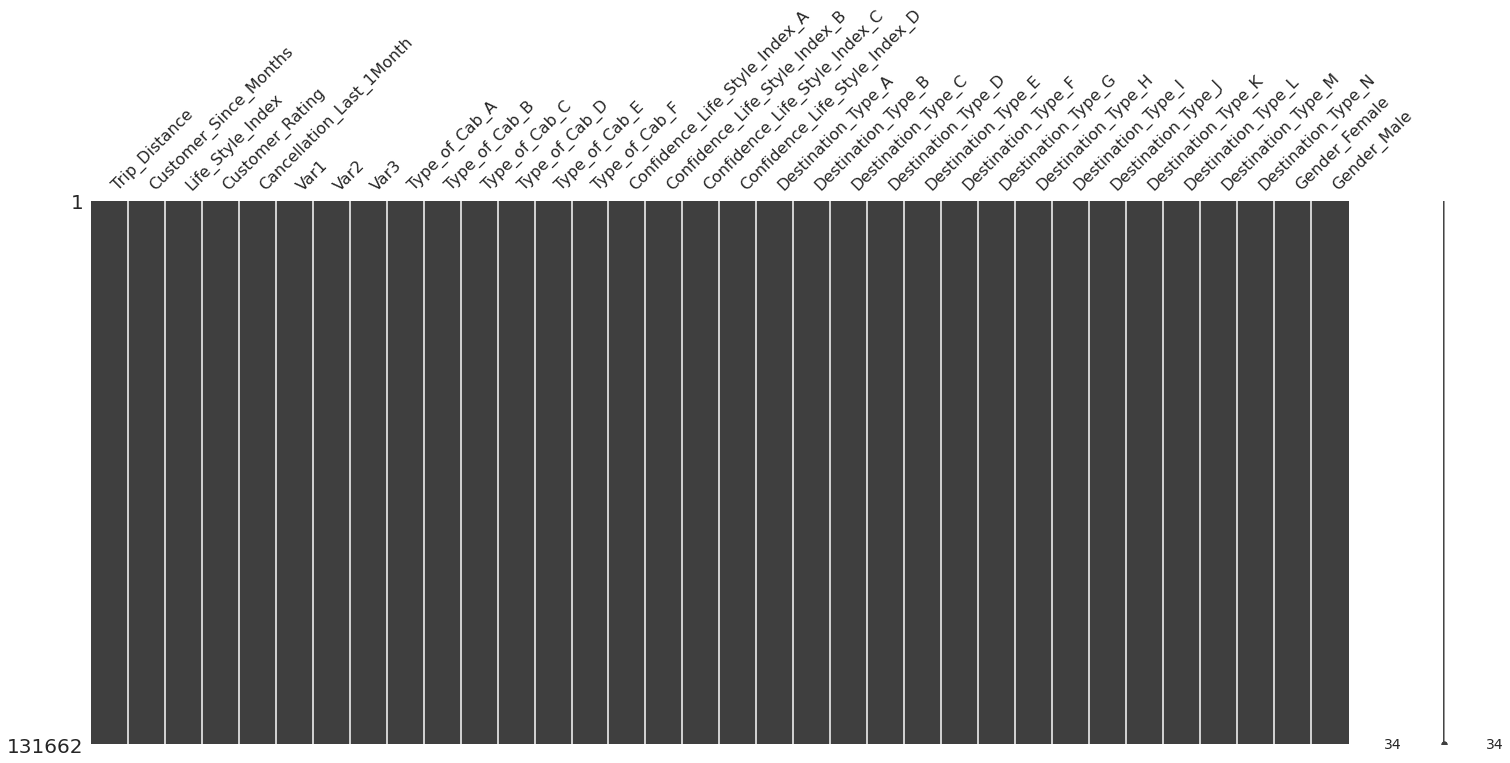

In [28]:
msno.matrix(train_prep_filled);

### Data input

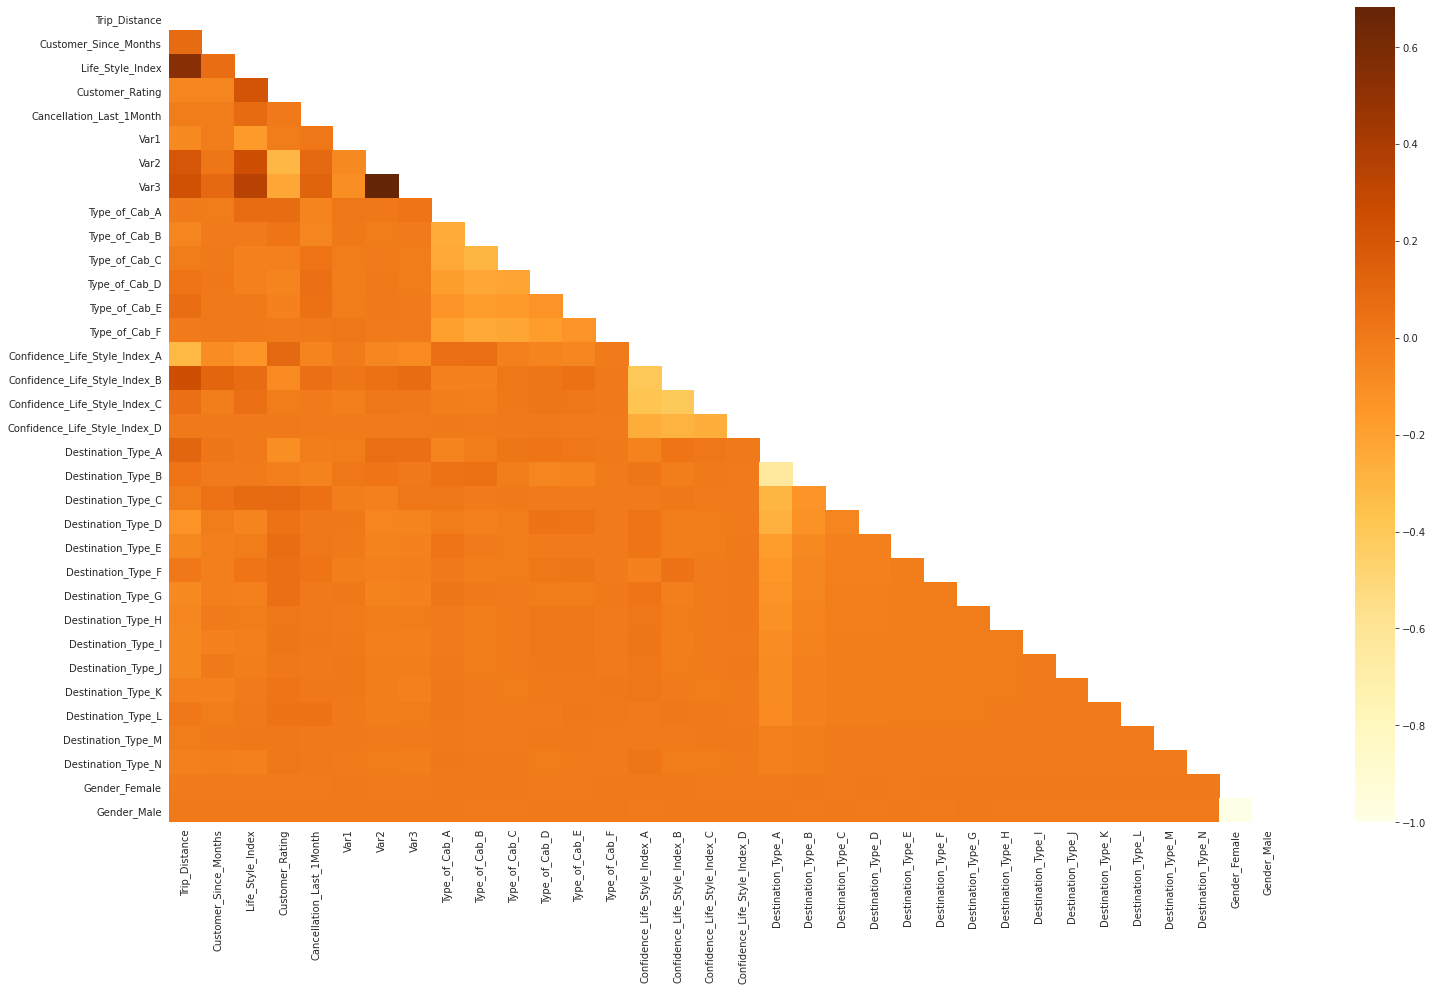

In [29]:
# heat map
corr = train_prep_filled.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

cmap = sns.color_palette("YlOrBr", as_cmap=True)

ax = sns.heatmap(corr, mask=mask, cmap=cmap)

redundant features from above heatmap are:
- male and female are correlated to each other and have similar correlation to label
- one feature from each dummies can also be reduced.

In [30]:
drop_cols = ['Destination_Type_M', 'Gender_Female', 'Confidence_Life_Style_Index_A', 'Type_of_Cab_F']
train_redundant = train_prep_filled.drop(columns=drop_cols, axis=1)
test_redundant = test_prep_filled.drop(columns=drop_cols, axis=1)

### Data storage

In [31]:
# join label to train for automl
train_data = pd.concat([train_redundant, label], axis=1, sort=False)

# save processed data to local
train_data.to_csv('train_processed.csv', index=False)
test_redundant.to_csv('test_processed.csv', index=False)

### Data processing

In [33]:
pip install h2o

     |████████████████████████████████| 164.6MB 73kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=0173f46cd6c37748fc1ca3cf418f04bd7b22b068090e719298e5ca178c563d68
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [34]:

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdzgdog_p
  JVM stdout: /tmp/tmpdzgdog_p/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdzgdog_p/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_vxmuxa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [35]:
trainFrame = h2o.import_file(path="train_processed.csv")
testFrame = h2o.import_file(path="test_processed.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [36]:
trainFrame['Surge_Pricing_Type'] = trainFrame['Surge_Pricing_Type'].asfactor()

In [37]:
aml = H2OAutoML(seed = 10, max_runtime_secs_per_model=65, max_models=20, exclude_algos = ['DeepLearning', 'StackedEnsemble'], verbosity='info')

In [38]:
X = trainFrame.columns
y = 'Surge_Pricing_Type'

In [39]:
aml.train(x = X, y = y, training_frame = trainFrame)

AutoML progress: |
10:22:56.160: Project: AutoML_20201223_102256157
10:22:56.164: Setting stopping tolerance adaptively based on the training frame: 0.0027559401129255536
10:22:56.165: Build control seed: 10
10:22:56.165: training frame: Frame key: automl_training_py_1_sid_84c9    cols: 31    rows: 131662  chunks: 8    size: 3814026  checksum: 5378449759036618039
10:22:56.165: validation frame: NULL
10:22:56.165: leaderboard frame: NULL
10:22:56.166: blending frame: NULL
10:22:56.166: response column: Surge_Pricing_Type
10:22:56.166: fold column: null
10:22:56.166: weights column: null
10:22:56.193: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
10:22:56.210: Disabling Algo: DeepLearning as requested by the user.
10:22:56.210: Disabling Algo: StackedEnsembl

In [40]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20201223_102256_model_3,0.323302,0.700685,0.486126,0.236319
XGBoost_grid__1_AutoML_20201223_102256_model_1,0.324431,0.705144,0.490146,0.240243
XGBoost_1_AutoML_20201223_102256,0.32536,0.707091,0.488325,0.238461
XGBoost_3_AutoML_20201223_102256,0.32545,0.698839,0.487345,0.237505
XGBoost_grid__1_AutoML_20201223_102256_model_4,0.326374,0.712668,0.493682,0.243722
XGBoost_grid__1_AutoML_20201223_102256_model_5,0.327334,0.702541,0.489471,0.239581
XGBoost_grid__1_AutoML_20201223_102256_model_6,0.32783,0.716438,0.490848,0.240932
GBM_4_AutoML_20201223_102256,0.332069,0.817365,0.551205,0.303827
GBM_grid__1_AutoML_20201223_102256_model_1,0.332362,0.86398,0.573099,0.328443
XGBoost_grid__1_AutoML_20201223_102256_model_2,0.334326,0.745236,0.508204,0.258272


In [41]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the GLM model
model_info = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0]) 

In [42]:
model_info

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20201223_102256_model_3


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.20841527757968228
RMSE: 0.45652522118682803
LogLoss: 0.6157003976887239
Mean Per-Class Error: 0.28757437159927207

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,Error,Rate
0,16104.0,8426.0,2684.0,0.408246,"11,110 / 27,214"
1,2412.0,46738.0,7578.0,0.176104,"9,990 / 56,728"
2,1877.0,11407.0,34436.0,0.278374,"13,284 / 47,720"
3,20393.0,66571.0,44698.0,0.261154,"34,384 / 131,662"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.738846
1,2,0.950206
2,3,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.2363188546593353
RMSE: 0.48612637725115815
LogLoss: 0.7006847888313195
Mean Per-Class Error: 0.3233023055015558

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,Error,Rate
0,15298.0,8707.0,3209.0,0.437863,"11,916 / 27,214"
1,2773.0,44814.0,9141.0,0.210020,"11,914 / 56,728"
2,2299.0,13068.0,32353.0,0.322024,"15,367 / 47,720"
3,20370.0,66589.0,44703.0,0.297709,"39,197 / 131,662"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.702291
1,2,0.930177
2,3,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7022907,9.678511E-4,0.7034899,0.7009076,0.7026052,0.7026052,0.70184565
1,err,0.2977093,9.678511E-4,0.29651007,0.29909238,0.2973948,0.2973948,0.29815432
2,err_count,7839.4,25.50098,7808.0,7876.0,7831.0,7831.0,7851.0
3,logloss,0.70068485,0.0026911933,0.6959951,0.700824,0.702025,0.70235205,0.70222795
4,max_per_class_error,0.43790424,0.0067666215,0.42739877,0.4433543,0.43830404,0.44423723,0.43622684
5,mean_per_class_accuracy,0.67668766,0.0020397834,0.679761,0.6743179,0.67713726,0.6755134,0.67670876
6,mean_per_class_error,0.32331234,0.0020397834,0.32023898,0.32568213,0.32286274,0.3244866,0.32329124
7,mse,0.23631887,0.0010738617,0.23450333,0.23676193,0.23632552,0.23730795,0.2366956
8,r2,0.5662698,0.0031471502,0.5709241,0.5638842,0.56676626,0.562863,0.5669114
9,rmse,0.48612538,0.0011057507,0.48425543,0.48658186,0.48613325,0.48714262,0.48651373



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-12-23 10:39:51,3 min 52.922 sec,0.0,0.666667,1.098612,0.637557
1,,2020-12-23 10:39:52,3 min 53.992 sec,5.0,0.517469,0.747877,0.292431
2,,2020-12-23 10:39:53,3 min 54.825 sec,10.0,0.487583,0.686506,0.286241
3,,2020-12-23 10:39:54,3 min 55.736 sec,15.0,0.476333,0.662068,0.279997
4,,2020-12-23 10:39:55,3 min 56.731 sec,20.0,0.469533,0.646619,0.274506
5,,2020-12-23 10:39:56,3 min 57.819 sec,25.0,0.464796,0.635524,0.270017
6,,2020-12-23 10:39:57,3 min 59.021 sec,30.0,0.460877,0.626185,0.266212
7,,2020-12-23 10:39:58,4 min 0.362 sec,35.0,0.457447,0.617997,0.262483
8,,2020-12-23 10:40:00,4 min 1.496 sec,36.0,0.456525,0.615700,0.261154



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Type_of_Cab_A,42760.968750,1.000000,0.198619
1,Type_of_Cab_B,36596.777344,0.855845,0.169987
2,Type_of_Cab_D,25745.738281,0.602085,0.119585
3,Type_of_Cab_C,22298.572266,0.521470,0.103574
4,Type_of_Cab_E,14654.017578,0.342696,0.068066
5,Trip_Distance,13756.291992,0.321702,0.063896
6,Customer_Rating,9100.256836,0.212817,0.042269
7,Var1,9015.027344,0.210824,0.041873
8,Life_Style_Index,8524.570312,0.199354,0.039595
9,Cancellation_Last_1Month,7925.767578,0.185351,0.036814



See the whole table with table.as_data_frame()


In [44]:
top_model = aml.leader # select top model from leaderboard

In [65]:
# predict using top model
prediction_list = h2o.as_list(top_model.predict(testFrame)[0], use_pandas=False)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [69]:
# create a submission file
submission_df = pd.concat([trips_test_raw['Trip_ID'], pd.DataFrame(prediction_list[1:], columns=['Surge_Pricing_Type'])], axis=1)

In [71]:
submission_df.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [72]:
# save to local
submission_df.to_csv('submission.csv', index=False)